# Engineering Time Features

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read Data

In [2]:
path_data = "../01_data/train.csv"
rentals = pd.read_csv(path_data)
rentals['datetime'] = pd.to_datetime(rentals['datetime'])

# Add time Features

## Time Series Attributes

**the `.dt` attribute of a datetime series allows us to grab several features/subsets of a time series, like hours, minutes, months.** 

Let's capitalize on that to develop new features!

In [10]:
rentals.datetime.dt.day_name()

0         Saturday
1         Saturday
2         Saturday
3         Saturday
4         Saturday
           ...    
10881    Wednesday
10882    Wednesday
10883    Wednesday
10884    Wednesday
10885    Wednesday
Name: datetime, Length: 10886, dtype: object

instead of repeating this step for every desired time feature manually:

```
rentals['weekdayname'] = rentals.datetime.dt.day_name()
```

We can develop a function that takes the desired attributes (hour, month) and creates a dataframe that we can add to our data.

In [13]:
# make function that cycles through time attrs and then adds a column to the df

def make_time_cols(time_att, time_series):
    
    feature_list = []

    for ta in time_att:
        try:

            dtobj = getattr(time_series, 'dt')

            feature_list.append(pd.Series(getattr(dtobj,ta), name = ta))
        except AttributeError:
            print(f'Time Attribute not present: {ta}')

    return pd.concat(feature_list, axis = 1)

In [14]:
time_atts = make_time_cols(time_att= ['year', 'dayofyear', 'month', 'day', 'weekday', 'hour'], time_series = rentals.datetime)
time_atts

,year,dayofyear,month,day,weekday,hour
0,2011,1,1,1,5,0
1,2011,1,1,1,5,1
2,2011,1,1,1,5,2
3,2011,1,1,1,5,3
4,2011,1,1,1,5,4
...,...,...,...,...,...,...
10881,2012,354,12,19,2,19
10882,2012,354,12,19,2,20
10883,2012,354,12,19,2,21
10884,2012,354,12,19,2,22


In [17]:
# join to the original data frame

rentals = pd.concat([rentals, time_atts], axis = 1)


In [18]:
# This is to remove the 0 in the hours, which (possibly?) helps with polynomial interactions
rentals['hour'] = rentals['hour'] + 1 # for polyfeatures



## Transformation


Some features have inherent characteristics that require special attention when using them in models. For example, this is the case when considering cyclic phenomaena. 

Are hours numeric values, categories, or ordinally spaced?

The problem is this across days, processes at 23 00 should be similar to processes at 01 00 - but increasing values (numeric, ordinal) don't account for that, and categories lose the relationship between adjacent hours.

A solution is to transform these features such that these time dependent relationships (e.g., December = 12, similar to January  = 1) are captured.



**Example**

In [73]:
hours = np.concatenate([np.linspace(1,24,24), np.linspace(1,24,24)], axis = -1)
time_actual = np.linspace(1, 48, 48)


sunshine = np.sin(hours * 2 * np.pi/48 ) + np.random.normal(0,0.2, 48)


In [74]:
hours.shape

(48,)

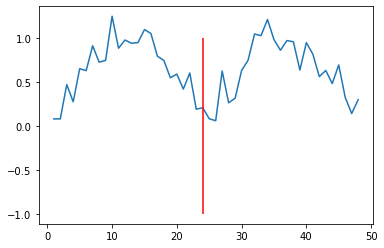

In [75]:
import matplotlib.pyplot as plt

plt.plot(time_actual, sunshine)
plt.vlines([24], ymin =  [-1], ymax = [1], color = 'red')

hour 2300 in value is much closer to hour 0100!

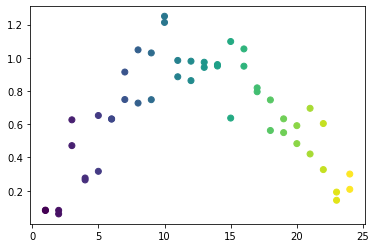

In [80]:
plt.scatter(hours, sunshine, c = hours)

We can transform the hour feature so that this dependence is represented in the values. A trigonometric transformation is sometimes used, which splits the hours into two components, a sin and a cos.

In [81]:
def cyclic_trans(pds, cycle):
    # only use on a single feature column!
    #https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning/notebook
    out = pd.DataFrame(
        {pds.name + "_sin" : np.sin(2 * np.pi * pds/cycle),
         pds.name + "_cos" : np.cos(2 * np.pi * pds/cycle) 

        }
        
    )

    return out


In [88]:
hours_series = pd.Series(hours, name = 'h')

ctrans = cyclic_trans(pds = hours_series, cycle = 24) # set this to the max number in the cycle, like 12 for months
ctrans

,h_sin,h_cos
0,2.588190e-01,9.659258e-01
1,5.000000e-01,8.660254e-01
2,7.071068e-01,7.071068e-01
3,8.660254e-01,5.000000e-01
4,9.659258e-01,2.588190e-01
5,1.000000e+00,6.123234e-17
6,9.659258e-01,-2.588190e-01
7,8.660254e-01,-5.000000e-01
8,7.071068e-01,-7.071068e-01
9,5.000000e-01,-8.660254e-01


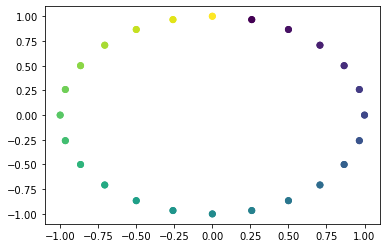

In [90]:
plt.scatter(ctrans.h_sin, ctrans.h_cos, c = hours)

These features (`h_sin` and `h_cos`) can now be used in a model, where the relationship between observations in a cycle will be represented.


This exercise can be repeated with months, seasons, weeks, etc.!